In [1]:
%load_ext autoreload
%autoreload 2


In [488]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yfinance as yf
from tqdm import tqdm
import requests

while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df
from src.preprocessing.finbert.sentiment import generate_sentiment_from_title

api_key = '64d11b117233d0.77790833'

## Moving average signal

In [493]:
prices = yf.download(
    'AMZN',
    start='2019-12-30',
    end='2022-12-30'
)

[*********************100%***********************]  1 of 1 completed


In [494]:
closing_prices = prices.Close

In [495]:
mva_fast = closing_prices\
    .rolling(3)\
    .mean()

mva_neutral = closing_prices\
    .rolling(6)\
    .mean()

mva_slow = closing_prices\
    .rolling(10)\
    .mean()

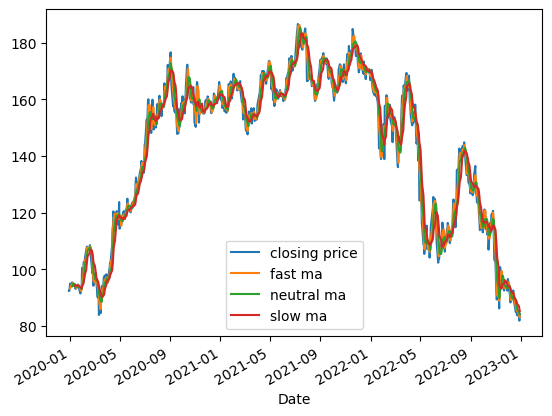

In [496]:
closing_prices.plot(
    label = "closing price"
)

mva_fast.plot(
    label = "fast ma"
)

mva_neutral.plot(
    label = "neutral ma"
)

mva_slow.plot(
    label = "slow ma"
)

plt.legend()
plt.show()

In [497]:
buy_signal = (mva_fast > mva_neutral) & (mva_neutral > mva_slow)
# buy_signal = mva_fast > mva_slow

In [498]:
sell_signal = (mva_fast < mva_neutral) & (mva_neutral < mva_slow)
# sell_signal = mva_fast < mva_slow

In [499]:
positions = pd.Series(
    0,
    index = closing_prices.index
)

In [500]:
positions.loc[buy_signal ] = 1
positions.loc[sell_signal] = -1 

In [501]:
def get_signal(x : pd.Series):
    print(x)
    if x.iloc[0] == 0 and x.iloc[1] != 0:
        if (x.iloc[1] > 0):
            return 1

        else:
            return -1

    if x.iloc[1] == 0 and x.iloc[0] != 0:
        if (x.iloc[0] > 0 ):
            return 0

        else:
            return 0

    return 0

def get_longshort_signal(x : pd.Series):
    
    if (x.iloc[0] != x.iloc[1]):
        if x.iloc[0] == -1:
            return 1

        elif x.iloc[0] == 1:
            return -1

    return 0

In [502]:
signals = positions.rolling(2).apply(get_signal)

Date
2019-12-30    0.0
2019-12-31    0.0
dtype: float64
Date
2019-12-31    0.0
2020-01-02    0.0
dtype: float64
Date
2020-01-02    0.0
2020-01-03    0.0
dtype: float64
Date
2020-01-03    0.0
2020-01-06    0.0
dtype: float64
Date
2020-01-06    0.0
2020-01-07    0.0
dtype: float64
Date
2020-01-07    0.0
2020-01-08    0.0
dtype: float64
Date
2020-01-08    0.0
2020-01-09    0.0
dtype: float64
Date
2020-01-09    0.0
2020-01-10    0.0
dtype: float64
Date
2020-01-10    0.0
2020-01-13    0.0
dtype: float64
Date
2020-01-13    0.0
2020-01-14    0.0
dtype: float64
Date
2020-01-14    0.0
2020-01-15   -1.0
dtype: float64
Date
2020-01-15   -1.0
2020-01-16   -1.0
dtype: float64
Date
2020-01-16   -1.0
2020-01-17   -1.0
dtype: float64
Date
2020-01-17   -1.0
2020-01-21    0.0
dtype: float64
Date
2020-01-21    0.0
2020-01-22    0.0
dtype: float64
Date
2020-01-22    0.0
2020-01-23    0.0
dtype: float64
Date
2020-01-23    0.0
2020-01-24    0.0
dtype: float64
Date
2020-01-24    0.0
2020-01-27   -1.0
dtype: 

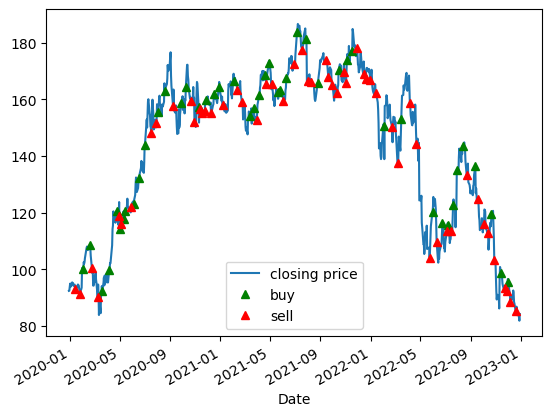

In [503]:
closing_prices.plot(
    label = "closing price"
)

closing_prices[signals == 1].plot(
    marker = "^",
    linestyle = "None",
    color = "green",
    label = "buy"
)

closing_prices[signals == -1].plot(
    marker = "^",
    linestyle = "None",
    color = "red",
    label = "sell"
)

plt.legend()

In [504]:
positions_df = pd.concat([positions, closing_prices], axis = 1)\
    .rename(columns = {0: "position"})

In [505]:
positions_df["position"].replace({1:2, -1: 1, 2: 1}, inplace = True)

In [506]:
positions_df

,position,Close
Date,,
2019-12-30,0,92.344498
2019-12-31,0,92.391998
2020-01-02,0,94.900497
2020-01-03,0,93.748497
2020-01-06,0,95.143997
...,...,...
2022-12-22,1,83.790001
2022-12-23,1,85.250000
2022-12-27,1,83.040001


In [507]:
pnl = pd.Series(
    0,
    index = positions_df.index
)

last_buy_price = np.nan
cash = 0
position = 0 

for date, row in tqdm(positions_df.iterrows()):
    first_trade = np.isnan(last_buy_price) and row["position"] != 0
    has_position = not np.isnan(last_buy_price)
    changing_position = has_position and row["position"] != position
    holding_position = has_position and row["position"] == position

    if (first_trade):
        last_buy_price = row["Close"]
        position = row["position"]

    if (changing_position):
        cash += (row["Close"] / last_buy_price - 1 )*position

        position = row["position"]
        if position ==0:
            last_buy_price = np.nan

        else :
            last_buy_price = row["Close"]
        # last_buy_price = np.nan
        # last_buy_price = row["close"]
        # position = row["position"]

    if holding_position:
        pnl.loc[date] = (row["Close"]- last_buy_price)/last_buy_price * position + cash

    else:
        pnl.loc[date] = cash

0it [00:00, ?it/s]

757it [00:00, 4481.26it/s]


<Axes: xlabel='Date'>

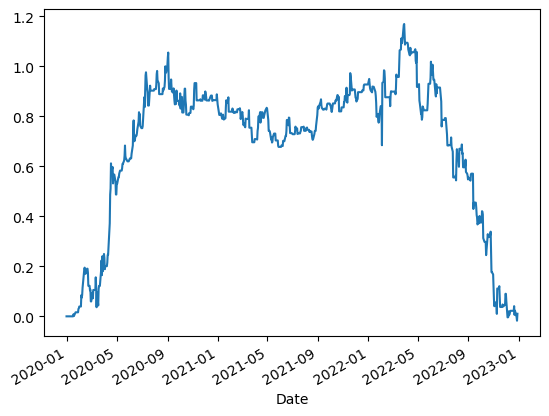

In [508]:
pnl.plot()

## Adding sentiment

In [510]:
sentiments = read_company_news_df("amazon")

In [512]:
sentiments["sentiment_count"] = sentiments["sentiment"]\
    .map({
        "neutral": 0,
        "negative": -1,
        "positive":1
    })

In [531]:
daily_sentiment = sentiments.groupby(
    by = pd.Grouper(key = "date", freq = "1d")
)\
    .mean()

/tmp/ipykernel_115987/2585694989.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [532]:
daily_sentiment.index = daily_sentiment.index.date

In [533]:
daily_sentiment= daily_sentiment.reindex(closing_prices.index)

In [541]:
daily_sentiment = daily_sentiment\
    ["sentiment_count"]\
    .apply(lambda x: np.sign(x))

In [559]:
sentiment_buy_signal = (daily_sentiment[buy_signal] > 0)\
    .reindex_like(buy_signal)\
    .fillna(False)
sentiment_sell_signal = (daily_sentiment[sell_signal] < 0)\
    .reindex_like(sell_signal)\
    .fillna(False)

In [560]:
positions = pd.Series(
    0,
    index = closing_prices.index
)

In [561]:
positions.loc[sentiment_buy_signal ] = 1
positions.loc[sentiment_sell_signal] = -1 

In [571]:
def get_signal(x : pd.Series):
    if x.iloc[0] == 0 and x.iloc[1] != 0:
        if (x.iloc[1] > 0):
            return 1

        else:
            return -1

    if x.iloc[1] == 0 and x.iloc[0] != 0:
        if (x.iloc[0] > 0 ):
            return 0.5

        else:
            return -.5

    return 0

def get_longshort_signal(x : pd.Series):
    
    if (x.iloc[0] != x.iloc[1]):
        if x.iloc[0] == -1:
            return 0.5

        elif x.iloc[0] == 1:
            return -0.5

    return 0

In [572]:
signals = positions.rolling(2).apply(get_signal)

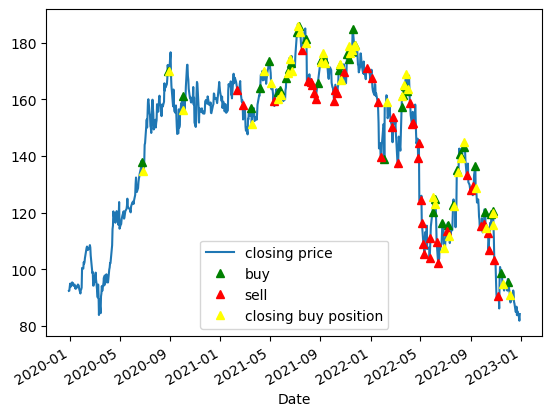

In [573]:
closing_prices.plot(
    label = "closing price"
)

closing_prices[signals == 1].plot(
    marker = "^",
    linestyle = "None",
    color = "green",
    label = "buy"
)

closing_prices[signals == -1].plot(
    marker = "^",
    linestyle = "None",
    color = "red",
    label = "sell"
)

closing_prices[signals == 0.5].plot(
    marker = "^",
    linestyle = "None",
    color = "yellow",
    label = "closing buy position"
)

plt.legend()

In [569]:
pnl = pd.Series(
    0,
    index = positions_df.index
)

last_buy_price = np.nan
cash = 0
position = 0 

for date, row in tqdm(positions_df.iterrows()):
    first_trade = np.isnan(last_buy_price) and row["position"] != 0
    has_position = not np.isnan(last_buy_price)
    changing_position = has_position and row["position"] != position
    holding_position = has_position and row["position"] == position

    if (first_trade):
        last_buy_price = row["Close"]
        position = row["position"]

    if (changing_position):
        cash += (row["Close"] / last_buy_price - 1 )*position

        position = row["position"]
        if position ==0:
            last_buy_price = np.nan

        else :
            last_buy_price = row["Close"]
        # last_buy_price = np.nan
        # last_buy_price = row["close"]
        # position = row["position"]

    if holding_position:
        pnl.loc[date] = (row["Close"]- last_buy_price)/last_buy_price * position + cash

    else:
        pnl.loc[date] = cash

757it [00:00, 4384.72it/s]


<Axes: xlabel='Date'>

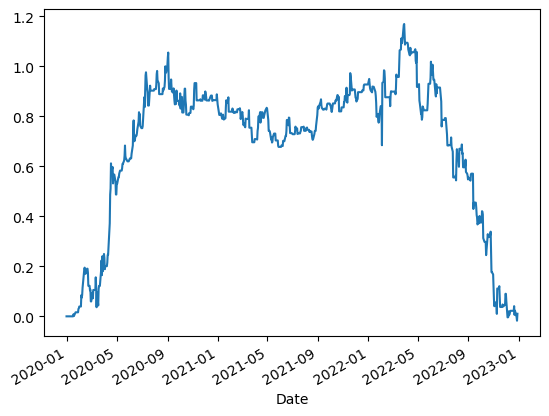

In [570]:
pnl.plot()